In [5]:
import os
import numpy as np
import pandas as pd
from scipy.interpolate import  interp1d

import pyradi.ryplot as ryplot
import pyradi.rymodtran as rymodtran
import pyradi.ryutils as ryutils

These runs were made with the desert albedo in the modtran albedo file replaced with the data in this folder.

|Run |ID|Path | H1 | H2 | Zenith | 
| --| ---| ---| ---|---|--|
|modobserver |o |slant path | 12.027|0.027| 118.8|
|modlow|l|slant path | 0.028 | 0.027| 118.8|
|modsun|s |slant path to space | 0.027| | 21.33 |
|modupper|u |slant path to space | 99|  |180 |



modobserver

     SUMMARY OF THE GEOMETRY CALCULATION

              H1      =   12.02700 KM
              H2      =    0.02700 KM
              ANGLE   =  118.80000 DEG
              RANGE   =   24.98084 KM
              BETA    =    0.19685 DEG
              PHI     =   61.37925 DEG
              HMIN    =    0.02700 KM
              BENDING =    0.01759 DEG
              LENN    =          0

modlow 

     SUMMARY OF THE GEOMETRY CALCULATION

              H1      =    0.02800 KM
              H2      =    0.02700 KM
              ANGLE   =  118.80000 DEG
              RANGE   =    0.00208 KM
              BETA    =    0.00002 DEG
              PHI     =   61.20002 DEG
              HMIN    =    0.02700 KM
              BENDING =   -0.00001 DEG
              LENN    =          0

modsun  (highest layer at 30.03 km)

 SUMMARY OF THE GEOMETRY CALCULATION

              H1      =    0.02700 KM
              H2      =   30.03000 KM
              ANGLE   =   21.33000 DEG
              RANGE   =   32.19862 KM
              BETA    =    0.10485 DEG
              PHI     =  158.76953 DEG
              HMIN    =    0.02700 KM
              BENDING =    0.00532 DEG
              LENN    =          0


modupper  (highest layer at 30.03 km)

     SUMMARY OF THE GEOMETRY CALCULATION

              H1      =    0.02700 KM
              H2      =   30.03000 KM
              ANGLE   =    0.00000 DEG
              RANGE   =   30.00300 KM
              BETA    =    0.00000 DEG
              PHI     =  180.00000 DEG
              HMIN    =    0.02700 KM
              BENDING =    0.00000 DEG
              LENN    =          0


In [6]:
def loadinter(filename,wli):
    tape7 = rymodtran.loadtape7(filename, ['FREQ', 'REF_SOL','DEPTH','SOL@OBS','GRND_RFLT','DRCT_RFLT'] )

    waven = tape7[:,0]

    # transmittance observer to ground
    tau = np.exp(-tape7[:,2])
    intfn = interp1d(1e4/waven,tau)
    tau = intfn(wli).reshape(-1,1)
    
    # convert from cm2 to m2
    refsoln = tape7[:,1]*1e4
    solobsn = tape7[:,3]*1e4
    grndrfltn = tape7[:,4]*1e4
    drctrfltn = tape7[:,5]*1e4

    # convert to per micron spectral density and interpolate to new vector
    (wavel, refsol) = ryutils.convertSpectralDensity(waven, refsoln, 'nl',outspecdomainFix=True,outspecdomain=wli)
    (wavel, solobs) = ryutils.convertSpectralDensity(waven, solobsn, 'nl',outspecdomainFix=True,outspecdomain=wli)
    (wavel, grndrflt) = ryutils.convertSpectralDensity(waven, grndrfltn, 'nl',outspecdomainFix=True,outspecdomain=wli)
    (wavel, drctrflt) = ryutils.convertSpectralDensity(waven, drctrfltn, 'nl',outspecdomainFix=True,outspecdomain=wli)
    
    return wavel, tau, refsol, solobs, grndrflt, drctrflt


In [9]:



wllong  = 1e4/10000.00
wli = np.linspace(1e4/33330.00, wllong,300)

# lod the three cases of modtran runa
wavelo, tauo, refsolo, solobso, grndrflto, drctrflto = loadinter('modobserver/tape5.tp7',wli)
wavels, taus, refsols, solobss, grndrflts, drctrflts = loadinter('modsun/tape5.tp7',wli)
wavell, taul, refsoll, solobsl, grndrfltl, drctrfltl = loadinter('modlow/tape5.tp7',wli)
wavelu, tauu, refsolu, solobsu, grndrfltu, drctrfltu = loadinter('modupper/tape5.tp7',wli)


albedod = np.loadtxt('albedo.dat')
intfn = interp1d(albedod[:,0],albedod[:,1])
albedo = intfn(wavelo).reshape(-1,1)


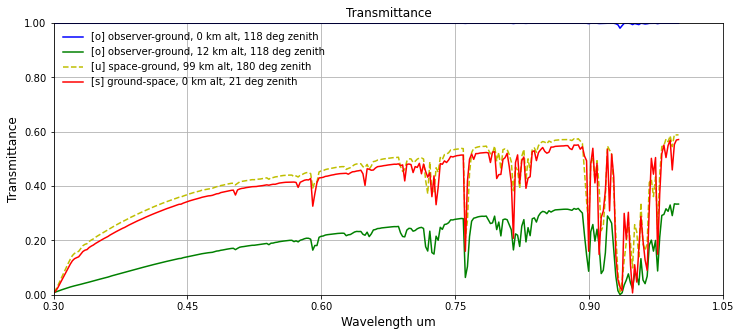

In [10]:

p = ryplot.Plotter(1, 1, 1, figsize=(12,5))
p.plot(1,wavelo,taul,label=['[o] observer-ground, 0 km alt, 118 deg zenith'],plotCol='b')
p.plot(1,wavelo,tauo,label=['[o] observer-ground, 12 km alt, 118 deg zenith'],plotCol='g')
p.plot(1,wavelo,tauu,label=['[u] space-ground, 99 km alt, 180 deg zenith'],linestyle=['--'],plotCol='y')
p.plot(1,wavelo,taus,'Transmittance','Wavelength um','Transmittance',plotCol='r',
       label=['[s] ground-space, 0 km alt, 21 deg zenith'],pltaxis=[0.3,wllong,0,1]);


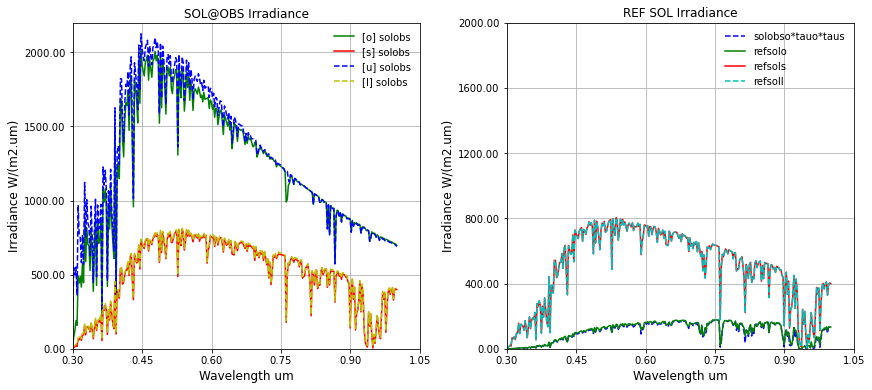

In [12]:

r = ryplot.Plotter(1, 1, 2, figsize=(14,6))

# r.plot(1,wavelo,solobso*taus,label=['solobso*taus'],plotCol='m')
r.plot(1,wavelo,solobso,label=['[o] solobs'],plotCol='g')
r.plot(1,wavelo,solobss+0,label=['[s] solobs'],plotCol='r')
r.plot(1,wavelo,solobsu-10,label=['[u] solobs'],linestyle=['--'],plotCol='b')
r.plot(1,wavelo,solobsl+10,label=['[l] solobs'],linestyle=['--'],plotCol='y',
       ptitle='SOL@OBS Irradiance',xlabel='Wavelength um',ylabel='Irradiance W/(m2.um)',
       pltaxis=[0.3,wllong,0,2200]);

r.plot(2,wavelo,solobso*tauo*taus,label=['solobso*tauo*taus'],plotCol='b',linestyle=['--'])
r.plot(2,wavelo,refsolo,label=['refsolo'],plotCol='g')
r.plot(2,wavelo,refsols,label=['refsols'],plotCol='r')
r.plot(2,wavelo,refsoll,label=['refsoll'],linestyle=['--'],plotCol='c',
       ptitle='REF SOL Irradiance',xlabel='Wavelength um',ylabel='Irradiance W/(m2.um)',
       pltaxis=[0.3,wllong,0,2000]);

# p.saveFig(os.path.join(datadir,'{}.png'.format(scenario)))


In [ ]:
q = ryplot.Plotter(2, 1, 1, figsize=(12,12))
q.plot(1,wavelo,solobso*tauo*taus*albedo,label=['direct: solobs*tauo*taus*albedo'],pltaxis=[0.3,wllong,0,120])
q.plot(1,wavelo, drctrflto*np.pi,label=['direct: drctrflt*np.pi'],pltaxis=[0.3,wllong,0,120])
q.plot(1,wavelo, refsolo*albedo,label=['direct: refsol*albedo'],pltaxis=[0.3,wllong,0,120])
q.plot(1,wavelo, grndrflto*np.pi,'Exitance','Wavelength um','Exitance W/(m2.um)',
       label=['direct+diffuse: grndrflt*np.pi'],pltaxis=[0.3,wllong,0,120]);



In [ ]:


# tape7 = rymodtran.loadtape7('modobserver/tape7', ['FREQ', 'REF_SOL','DEPTH','SOL@OBS','GRND_RFLT','DRCT_RFLT'] )
# tape7s = rymodtran.loadtape7('modsun/tape7s', ['FREQ', 'REF_SOL','DEPTH','SOL@OBS','GRND_RFLT','DRCT_RFLT'] )
# tape7l = rymodtran.loadtape7('modlow/tape7l', ['FREQ', 'REF_SOL','DEPTH','SOL@OBS','GRND_RFLT','DRCT_RFLT'] )


# waven = tape7[:,0]

# # transmittance observer to ground
# tauo = np.exp(-tape7[:,2])
# tauo = tauo.reshape(-1,1)

# # transmittance sun to ground
# taus = np.exp(-tape7s[:,2])
# taus = taus.reshape(-1,1)


# # TSNREF: sun-final_altitude sensor solar irradiance [real]
# # W/m2.cm-1
# refsoln = tape7[:,1]*1e4
# solobsn = tape7[:,3]*1e4
# grndrfltn = tape7[:,4]*1e4
# drctrfltn = tape7[:,5]*1e4


# # convert to microns
# (wavel, refsol) = ryutils.convertSpectralDensity(waven, refsoln, 'nl')
# (wavel, solobs) = ryutils.convertSpectralDensity(waven, solobsn, 'nl')
# (wavel, grndrflt) = ryutils.convertSpectralDensity(waven, grndrfltn, 'nl')
# (wavel, drctrflt) = ryutils.convertSpectralDensity(waven, drctrfltn, 'nl')

# intfn = interp1d(albedod[:,0],albedod[:,1])
# albedo = intfn(wavel).reshape(-1,1)

# p = ryplot.Plotter(1, 3, 1, figsize=(12,12))


# p.plot(1,wavel,tauo,label=['observer-ground'],pltaxis=[0.3,wllong,0,1])
# p.plot(1,wavel,taus,'Transmittance','Wavelength um','Transmittance',
#        label=['sun-ground'],pltaxis=[0.3,wllong,0,1])

# p.plot(2,wavel,refsol,label=['refsol: solobs*taus*tauo'],pltaxis=[0.3,wllong,0,2000])
# p.plot(2,wavel,solobs,'Irradiance','Wavelength um','Irradiance W/(m2.um)',
#        label=['solobs: Extra-terrestrial'],pltaxis=[0.3,wllong,0,2000])

# p.plot(3,wavel,solobs*tauo*taus*albedo,label=['direct: solobs*tauo*taus*albedo'],pltaxis=[0.3,wllong,0,120])
# p.plot(3,wavel, drctrflt*np.pi,label=['direct: drctrflt*np.pi'],pltaxis=[0.3,wllong,0,120])
# p.plot(3,wavel, refsol*albedo,label=['direct: refsol*albedo'],pltaxis=[0.3,wllong,0,120])
# p.plot(3,wavel, grndrflt*np.pi,'Exitance','Wavelength um','Exitance W/(m2.um)',
#        label=['direct+diffuse: grndrflt*np.pi'],pltaxis=[0.3,wllong,0,120]);

# # p.saveFig(os.path.join(datadir,'{}.png'.format(scenario)))

